# CNN on MNIST Data 
---

Link to colab : https://colab.research.google.com/drive/1J-987TBl3NdJoGsY90F6XpmfSQAztQ5O


**Target**:

> Increase starting train/test accuracy of model keeping parameters less than 10k. As Batch Normalization normalizes the channel/layer outputs, the internal channel outputs is no longer affected by contrasts and jitters in the images as we saw in previous file. It focuses only on edges and patterns. Thus, it would help in increasing the starting accuracy.

**Results**:

> Parameters: 10,056

> Best Train Accuracy: 99.53%

> Best Test Accuracy: 99.19%

**Analysis**:

> As we saw, batch normalization increased the beginning accuracy. So, now I was able to reach around 99% test accuracy. 

> We see that the number of parameters has exceeded 10k.

> There is also slight overfitting in training.


## Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

%matplotlib inline
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## The model
---

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16)
        ) # input_size = 28x28x1, output_size = 26x26x16, RF = 3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(32)
        ) # input_size = 26x26x16, output_size = 24x24x32, RF = 5x5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # input_size = 24x24x32, output_size = 24x24x10, RF = 5x5
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 24x24x10, output_size = 12x12x10, RF = 6x6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10)
        ) # input_size = 12x12x10, output_size = 10x10x10, RF = 10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16)
        ) # input_size = 10x10x10, output_size = 8x8x16, RF = 14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16)
        ) # input_size = 8x8x16, output_size = 6x6x16, RF = 18x18
                
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # input_size = 6x6x16, output_size = 1x1x16, RF = 38x38

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # input_size = 6x6x16, output_size = 1x1x16, RF = 38x38
        

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
            Conv2d-4           [-1, 32, 24, 24]           4,608
              ReLU-5           [-1, 32, 24, 24]               0
       BatchNorm2d-6           [-1, 32, 24, 24]              64
            Conv2d-7           [-1, 10, 24, 24]             320
         MaxPool2d-8           [-1, 10, 12, 12]               0
            Conv2d-9           [-1, 10, 10, 10]             900
             ReLU-10           [-1, 10, 10, 10]               0
      BatchNorm2d-11           [-1, 10, 10, 10]              20
           Conv2d-12             [-1, 16, 8, 8]           1,440
             ReLU-13             [-1, 16, 8, 8]               0
      BatchNorm2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [8]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.1163427010178566 Batch_id=468 Accuracy=88.77: 100%|██████████| 469/469 [00:11<00:00, 41.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0836, Accuracy: 9809/10000 (98.09%)

EPOCH: 2


Loss=0.059040289372205734 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:10<00:00, 42.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0629, Accuracy: 9821/10000 (98.21%)

EPOCH: 3


Loss=0.06133008003234863 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:11<00:00, 40.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9877/10000 (98.77%)

EPOCH: 4


Loss=0.020292798057198524 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:11<00:00, 40.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9887/10000 (98.87%)

EPOCH: 5


Loss=0.03892380744218826 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:11<00:00, 41.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9877/10000 (98.77%)

EPOCH: 6


Loss=0.0517362616956234 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:11<00:00, 48.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9884/10000 (98.84%)

EPOCH: 7


Loss=0.029162252321839333 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:11<00:00, 41.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9885/10000 (98.85%)

EPOCH: 8


Loss=0.047667067497968674 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:11<00:00, 41.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9900/10000 (99.00%)

EPOCH: 9


Loss=0.004909783601760864 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:11<00:00, 41.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.03695681318640709 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:11<00:00, 41.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9915/10000 (99.15%)

EPOCH: 11


Loss=0.0032352458219975233 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:10<00:00, 43.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9917/10000 (99.17%)

EPOCH: 12


Loss=0.018043920397758484 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:10<00:00, 43.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9903/10000 (99.03%)

EPOCH: 13


Loss=0.026752525940537453 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:11<00:00, 41.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9919/10000 (99.19%)

EPOCH: 14


Loss=0.004845882300287485 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:10<00:00, 42.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9916/10000 (99.16%)

EPOCH: 15


Loss=0.01519377063959837 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:11<00:00, 41.48it/s]



Test set: Average loss: 0.0263, Accuracy: 9917/10000 (99.17%)



Text(0.5, 1.0, 'Test Accuracy')

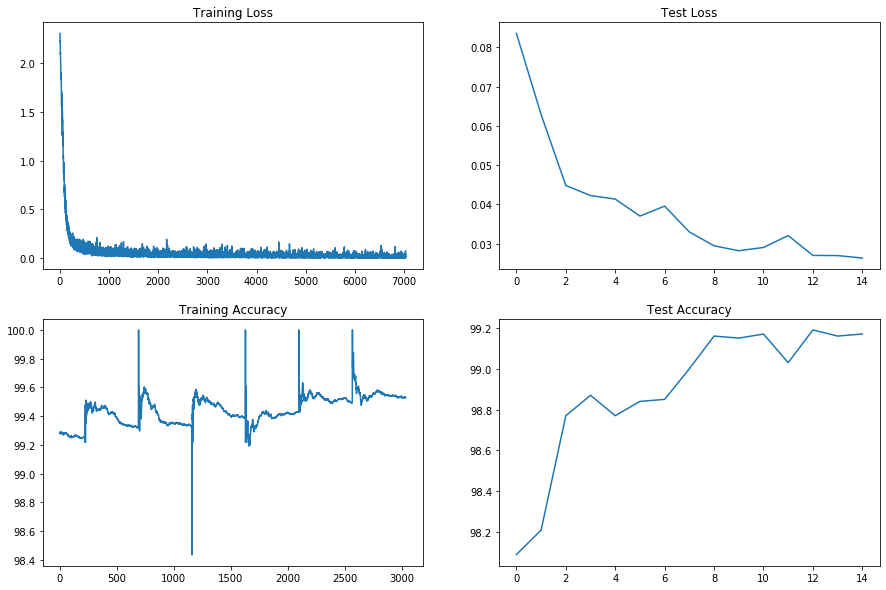

In [9]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")